In [2]:
import torch
import torch.nn as nn
import torch._utils
import numpy as np

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=None):
        super(BasicBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            )
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.layer(x)
        if self.downsample is not None:
            residual = self.downsample(x)      
        out = out + residual
        out = self.relu(out)
        return out

In [3]:
class HRNet(nn.Module):
    def __init__(self, block_type, in_channels_list, out_channels_list, is_final=False):
        super(HRNet, self).__init__()
        self.in_channels_list = in_channels_list
        self.out_channels_list = out_channels_list
        self.is_final = is_final
        self.branches = self.make_branches(block_type, in_channels_list)
        self.fuse_layers = self.make_fuse_layers(in_channels_list, out_channels_list)
        if self.is_final is True: # 最后一层
            self.concatenate_layers = self.make_concatenate_layers(self.out_channels_list)
    
    def make_branches(self, block_type, channels_list):
        branches = nn.ModuleList()
        for i in range(len(channels_list)):
            branch = nn.Sequential()
            branch.append(block_type(channels_list[i],channels_list[i]))
            branch.append(block_type(channels_list[i],channels_list[i]))
            branch.append(block_type(channels_list[i],channels_list[i]))
            branches.append(branch)
        return branches

    def make_fuse_layers(self, in_channels_list, out_channels_list):
        fuse_layers = nn.ModuleList()
        for o in range(len(out_channels_list)):
            fuse_layer = nn.ModuleList()
            for i in range(len(in_channels_list)):
                layer = nn.Sequential()
                if o > i:   # 下采样
                    for num in range(o - i):
                        # layer.append(nn.MaxPool2d(kernel_size=2, stride=2))
                        layer.append(nn.Conv2d(in_channels=in_channels_list[i], out_channels=out_channels_list[i], kernel_size=3, stride=2, padding=1))
                        layer.append(nn.BatchNorm2d(out_channels_list[i]))
                        layer.append(nn.ReLU())
                    layer.append(nn.Conv2d(in_channels=in_channels_list[i], out_channels=out_channels_list[o], kernel_size=1))
                    layer.append(nn.BatchNorm2d(out_channels_list[o]))
                    layer.append(nn.ReLU())
                elif o < i: # 上采样
                    for num in range(i - o):
                        layer.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))
                    layer.append(nn.Conv2d(in_channels=in_channels_list[i], out_channels=out_channels_list[o], kernel_size=1))
                    layer.append(nn.BatchNorm2d(out_channels_list[o]))
                    layer.append(nn.ReLU())
                else: 
                    layer.append(nn.Conv2d(in_channels=in_channels_list[i], out_channels=out_channels_list[o], kernel_size=1))
                    layer.append(nn.BatchNorm2d(out_channels_list[o]))
                    layer.append(nn.ReLU())
                fuse_layer.append(layer)
            fuse_layers.append(fuse_layer)
        return fuse_layers

    def make_concatenate_layers(self, channels_list):
        concatenate_layers = nn.ModuleList()
        for i in range(len(channels_list)):
            layer = nn.Sequential()
            for num in range(i):
                layer.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))
            layer.append(nn.Conv2d(in_channels=channels_list[i], out_channels=channels_list[0], kernel_size=1))
            layer.append(nn.BatchNorm2d(channels_list[0]))
            layer.append(nn.ReLU())
            concatenate_layers.append(layer)
        return concatenate_layers

    def forward(self, input):
        y = []
        for i, x in enumerate(input):
            y.append(self.branches[i](x))
        output = []
        for o in range(len(self.out_channels_list)):
            sum = None
            for i in range(len(self.in_channels_list)):
                out = self.fuse_layers[o][i](y[i])
                if i == 0:
                    sum = out
                else:
                    sum = sum + out
            output.append(sum)
        if self.is_final is True: # 最后一层
            final_output = None
            for i, x in enumerate(output):
                if i == 0:
                    final_output = self.concatenate_layers[i](x)
                else:
                    final_output = final_output + self.concatenate_layers[i](x)
            return final_output
        return output

In [4]:
class HRNet_Model(nn.Module):
    def __init__(self):
        super(HRNet_Model, self).__init__()
        self.net0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.net1 = HRNet(block_type=BasicBlock, in_channels_list=[64], out_channels_list=[64, 128])
        self.net2 = HRNet(block_type=BasicBlock, in_channels_list=[64, 128], out_channels_list=[64, 128, 256])
        self.net3 = HRNet(block_type=BasicBlock, in_channels_list=[64, 128, 256], out_channels_list=[64, 128, 256], is_final=True)
        self.net4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            nn.ReLU(),
        )
    def forward(self, input):
        output = [self.net0(input)]
        output = self.net1(output)
        output = self.net2(output)
        output = self.net3(output)
        output = self.net4(output)
        return output

In [5]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, targets):
        N = targets.size(0)
        input_flat = input.view(N, -1)
        targets_flat = targets.view(N, -1)
        intersection = input_flat * targets_flat 
        N_dice_eff = (2 * intersection.sum(1) + self.smooth) / (input_flat.sum(1) + targets_flat.sum(1) + self.smooth)
        loss = 1 - N_dice_eff.sum() / N
        return loss

In [6]:
from torch.utils.data import Dataset, DataLoader

class DRIVE_dataset(Dataset):
    def __init__(self, img, label):
        self.img = img
        self.label = label

    def __len__(self):
        return self.label.shape[0]
    
    def __getitem__(self, index):
        img = self.img[index]
        label = self.label[index]
        return img, label

In [6]:
from PIL import Image
import numpy as np
import os

img_h = 512
img_w = 512
X_train = np.zeros((20, img_h, img_w, 1))
y_train = np.zeros((20, img_h, img_w, 1))
train_image_path = ['DRIVE_processed/train/image']
target_path = ['DRIVE_processed/train/target']
# X_train = np.zeros((40, img_h, img_w, 1))
# y_train = np.zeros((40, img_h, img_w, 1))
# train_image_path = ['DRIVE_processed/train/image', 'STARE_processed/image']
# target_path = ['DRIVE_processed/train/target','STARE_processed/target']

def read_train_image(dicts):
    i = 0
    for directory in dicts:  
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.png'):
                    file_path = os.path.join(root, file)
                    image = Image.open(file_path)
                    X_train[i] = np.array(image).reshape(img_h, img_w, 1)
                    i = i + 1
def read_target(dicts):
    i = 0
    for directory in dicts:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.png'):
                    
                    file_path = os.path.join(root, file)
                    image = Image.open(file_path)
                    y_train[i] = np.array(image).reshape(img_h, img_w, 1)
                    i += 1

read_train_image(train_image_path)
read_target(target_path)

In [7]:
import cv2
import random

def apply_transform(image, rotation_angle, horizontal_flip, vertical_flip):
    if horizontal_flip:
        image = cv2.flip(image, 1)  # 1 表示水平翻转
    if vertical_flip:
        image = cv2.flip(image, 0)  # 0 表示垂直翻转
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))
    return image.reshape(h, w, 1)

num_new = 20
X_new = np.zeros((num_new, img_h, img_w, 1))
y_new = np.zeros((num_new, img_h, img_w, 1))
for i in range(num_new):
    horizontal_flip = random.randint(0, 1)
    vertical_flip = random.randint(0, 1)
    rotation_angle = random.randint(-30, 30)
    X_new[i] = apply_transform(X_train[i], rotation_angle, horizontal_flip, vertical_flip)
    y_new[i] = apply_transform(y_train[i], rotation_angle, horizontal_flip, vertical_flip)
X_train = np.append(X_train, values=X_new, axis=0)
y_train = np.append(y_train, values=y_new, axis=0)

X_train = X_train.transpose(0, 3, 1, 2)
y_train = y_train.transpose(0, 3, 1, 2)

In [8]:
import torch.optim as optim 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

epochs = 25
batch_size = 1
train_dataset = DRIVE_dataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
model = HRNet_Model().to(device)
criterion = DiceLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
acc = 0

model.train()
for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(torch.float32).to(device)
        labels = labels.to(torch.float32).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'epoch: {epoch+1}| {(i+1)*batch_size} loss:{loss}')
        
torch.save(model, f'model_{img_h}_processed.pth')

epoch: 1| 1 loss:0.367922306060791
epoch: 1| 2 loss:-2.8959689140319824
epoch: 1| 3 loss:-7.935396194458008
epoch: 1| 4 loss:-10.137451171875
epoch: 1| 5 loss:-12.277389526367188
epoch: 1| 6 loss:-16.777416229248047
epoch: 1| 7 loss:-17.44097137451172
epoch: 1| 8 loss:-19.830583572387695
epoch: 1| 9 loss:-22.448801040649414
epoch: 1| 10 loss:-22.61467933654785
epoch: 1| 11 loss:-24.768516540527344
epoch: 1| 12 loss:-25.290904998779297
epoch: 1| 13 loss:-25.372127532958984
epoch: 1| 14 loss:-18.23077964782715
epoch: 1| 15 loss:-26.41175651550293
epoch: 1| 16 loss:-23.536792755126953
epoch: 1| 17 loss:-26.713354110717773
epoch: 1| 18 loss:-27.432302474975586
epoch: 1| 19 loss:-26.79174041748047
epoch: 1| 20 loss:-30.168798446655273
epoch: 1| 21 loss:-30.134246826171875
epoch: 1| 22 loss:-27.501386642456055
epoch: 1| 23 loss:-25.704431533813477
epoch: 1| 24 loss:-25.044118881225586
epoch: 1| 25 loss:-25.545902252197266
epoch: 1| 26 loss:-29.52278709411621
epoch: 1| 27 loss:-28.47921943664

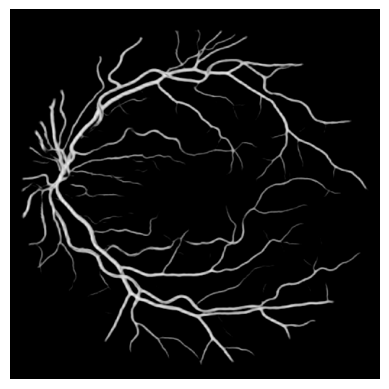

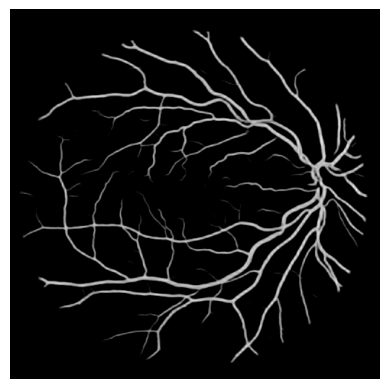

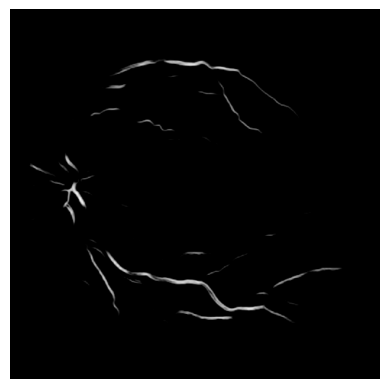

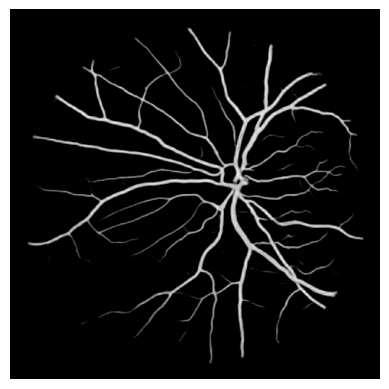

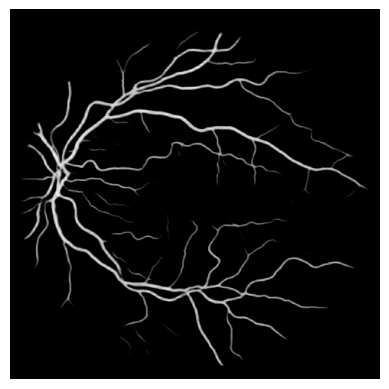

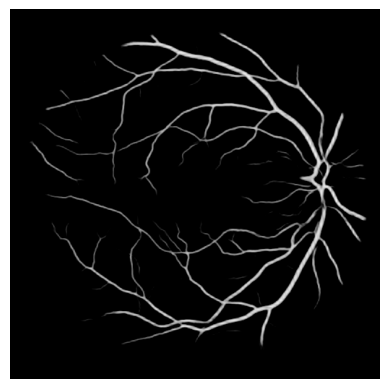

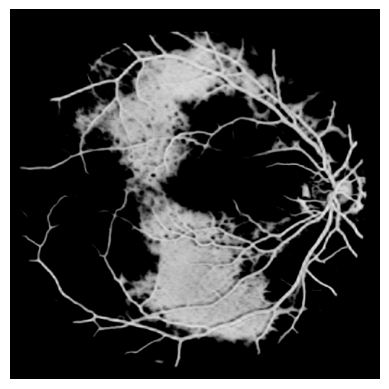

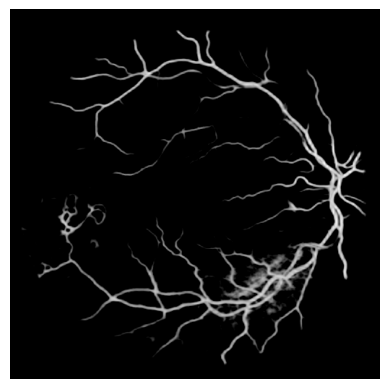

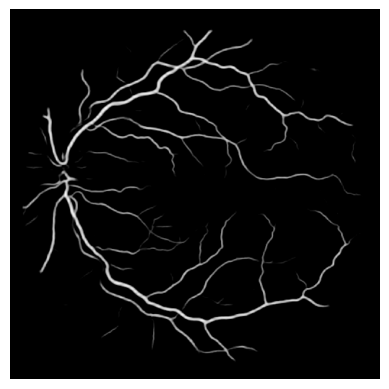

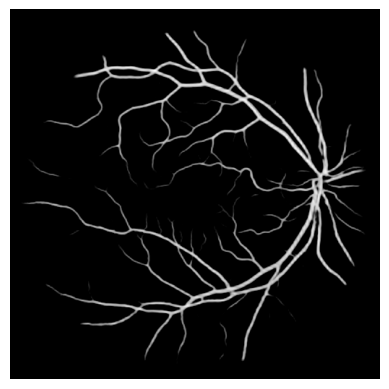

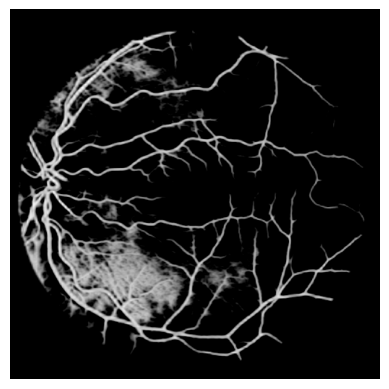

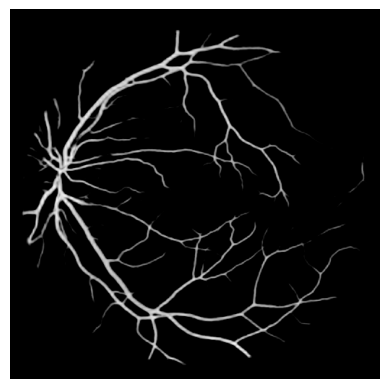

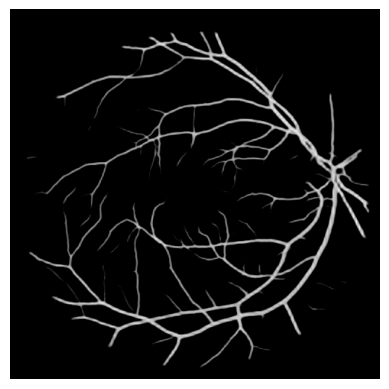

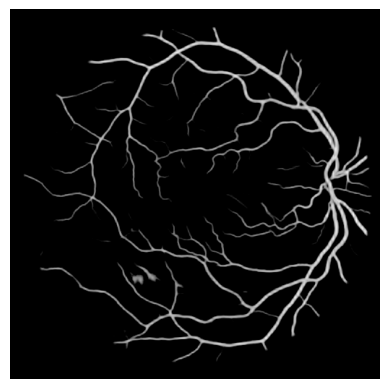

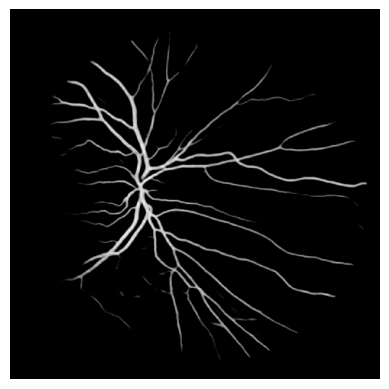

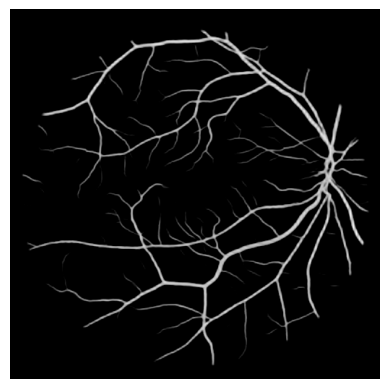

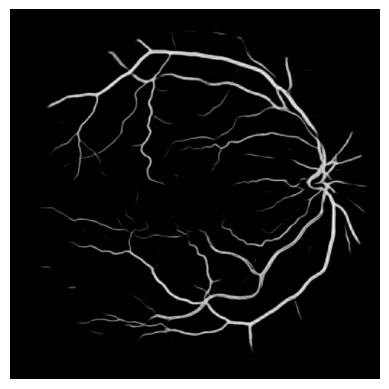

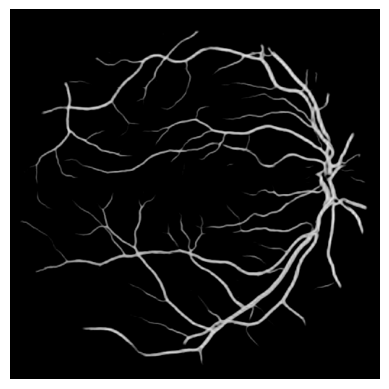

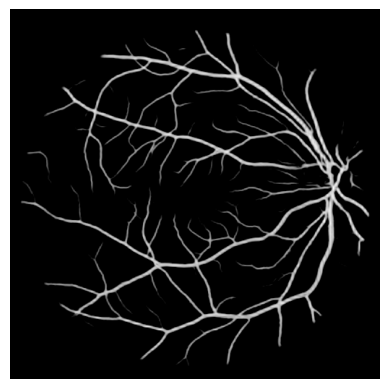

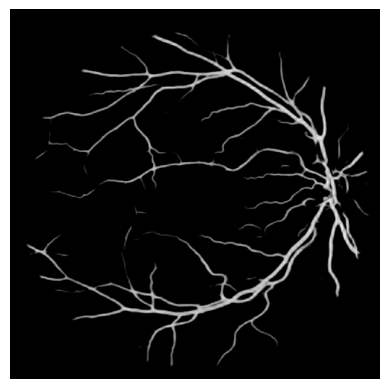

In [9]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

img_h = 512
img_w = 512
def read_test_image(dicts):
    i = 0
    for directory in dicts:  
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.endswith('.png'):
                    file_path = os.path.join(root, file)
                    image = Image.open(file_path)
                    X_test[i] = np.array(image).reshape(img_h, img_w, 1)
                    i = i + 1
                    
# image_test_path = ['FGADR_processed']
# X_test = np.zeros((5, img_h, img_w, 1))
# y_test = np.zeros(5)

image_test_path = ['DRIVE_processed/test']
X_test = np.zeros((20, img_h, img_w, 1))
y_test = np.zeros(20)
read_test_image(image_test_path)
X_test = X_test.transpose(0, 3, 1, 2)

batch_size = 1
test_dataset = DRIVE_dataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

model = torch.load('model_512_processed.pth', map_location='cpu') # cpu
# model = torch.load( f'model_{img_h}_processed.pth')
model.eval()
for i, (inputs, labels) in enumerate(test_dataloader):
    inputs = inputs.to(torch.float32) # cpu
    # inputs = inputs.to(torch.float32).to(device)
    outputs = model(inputs)
    for j in range(batch_size):
        img_out = outputs[j].detach().numpy().transpose(1, 2, 0) # cpu
        # img_out = outputs[j].cpu().detach().numpy().transpose(1, 2, 0)
        plt.imshow(img_out, cmap='gray')
        plt.axis('off')
        plt.show()
        cv2.imwrite(f'./output_512/{i+1}.png', img_out)